In [1]:
%matplotlib inline

import gym
import matplotlib
import numpy as np
import sys

from collections import defaultdict
if "../" not in sys.path:
  sys.path.append("../") 
from lib.envs.blackjack import BlackjackEnv
from lib import plotting

matplotlib.style.use('ggplot')

In [2]:
env = BlackjackEnv()

In [3]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        # 根据Q表，决定哪个概率变大
        action_probs = np.ones(nA, dtype=float) * epsilon / nA
        best_action = np.argmax(Q[observation])
        action_probs[best_action] += (1 - epsilon)
        return action_probs
        
    return policy_fn

In [4]:
def mc_control_epsilon_greedy(env, num_episodes, discount_factor=1.0, epsilon=0.1):
    """
    Monte Carlo Control using Epsilon-Greedy policies.
    Finds an optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Nubmer of episodes to sample.
        discount_factor: Lambda discount factor.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function taht takes an observation as an argument and returns
        action probabilities
    """
    
    # Keeps track of sum and count of returns for each state
    # to calculate an average. We could use an array to save all
    # returns (like in the book) but that's memory inefficient.
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    # MC方法生成多个episode，每个episode中更新Q和policy
    for i_episode in range(1, num_episodes+1):
        # Print out which episode we're on, useful for debugging.
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end='')
            sys.stdout.flush()
        
        # 使用当前policy,生成mento-carlo样本
        state = env.reset()
        series = [] # (state, action, reward)样本
        for t in range(0,100): # 肯定不会超出100步
            action_probs = policy(state)  # 此处动态引用Q，policy会随Q变化
            action = np.random.choice(np.arange(len(action_probs)), p = action_probs)
            next_state, reward, done, _ = env.step(action)
            series.append((state, action, reward))
            if done:
                break
            state = next_state

        state_action_set = set([(state, action) for state, action, _ in series])
        for state, action in state_action_set:
            # 找到state, action第一次出现
            first_index = next(i for i, (state_i, action_i, _) in enumerate(series) \
                               if state_i == state and action_i == action)
            # 计算奖励
            G = sum([reward*(discount_factor**i) \
                     for i, (_,_, reward) in enumerate(series[first_index:])])
            
            # 更新状态行为函数
            returns_sum[(state,action)] += G
            returns_count[(state,action)] += 1
            Q[state][action] = returns_sum[(state,action)] / returns_count[(state,action)]
        
        # 根据Q，更新当前policy
        # policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
        # 无需更新policy，它由Q表完全决定行为
    
    return Q, policy

In [5]:
Q, policy = mc_control_epsilon_greedy(env, num_episodes=500000, epsilon=0.1)

Episode 500000/500000.

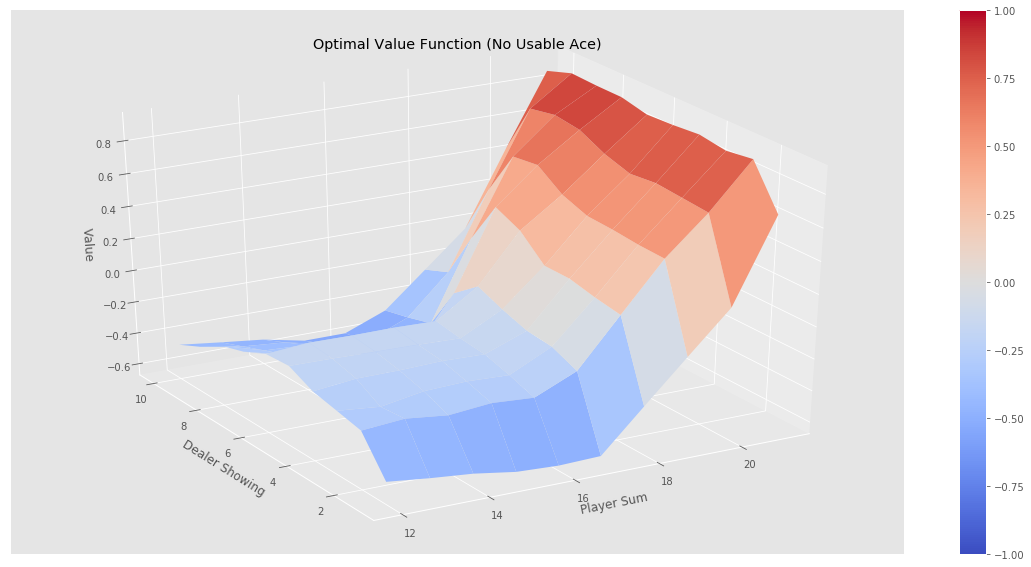

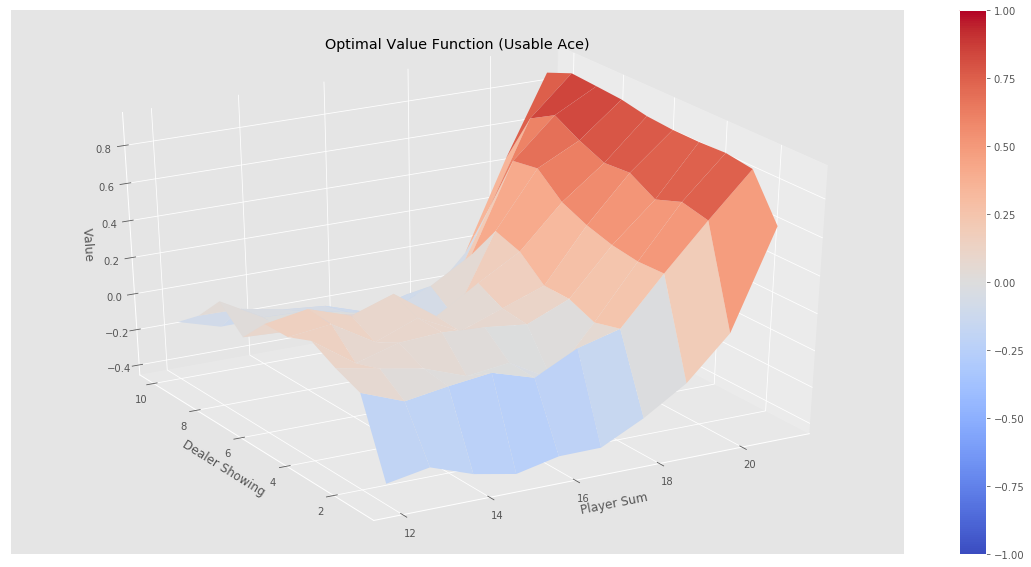

In [6]:
# For plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
for state, actions in Q.items():
    action_value = np.max(actions)
    V[state] = action_value
plotting.plot_value_function(V, title="Optimal Value Function")